# 1 Предобработка

### 1.1 Очистка и нормализация текста

In [1]:
import pandas as pd

data = pd.read_csv(
    r'data\raw_dataset.csv',
    encoding='latin-1',
    header=None,
    names=['target', 'id', 'date', 'flag', 'user', 'text']
)

data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


<Axes: >

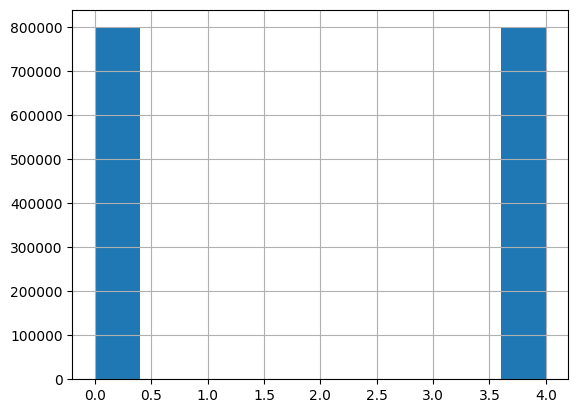

In [2]:
data['target'].hist()

В нижний регистр

In [3]:
text_lower = data['text'].str.lower()

text_lower

0          @switchfoot http://twitpic.com/2y1zl - awww, t...
1          is upset that he can't update his facebook by ...
2          @kenichan i dived many times for the ball. man...
3            my whole body feels itchy and like its on fire 
4          @nationwideclass no, it's not behaving at all....
                                 ...                        
1599995    just woke up. having no school is the best fee...
1599996    thewdb.com - very cool to hear old walt interv...
1599997    are you ready for your mojo makeover? ask me f...
1599998    happy 38th birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @thenspcc @sparkscharity...
Name: text, Length: 1600000, dtype: object

Удаление ссылок итд + удаление дубликатов

In [4]:
import re

# ссылки и домены
URL_RE = re.compile(r'(https?://\S+|www\.\S+|[a-zA-Z0-9\-]+\.[a-zA-Z]{2,})')
# упоминания
MENTION_RE = re.compile(r'@\w+')
# хэштеги
HASHTAG_RE = re.compile(r'#\w+')

# оставить только латиницу/цифры/пробелы и пунктуацию . , '
ALLOWED_CHARS_RE = re.compile(r"[^a-z0-9\s\.\,']")

# схлопывание повторов:
# 1) буквы: 3+ одинаковых подряд -> 2 (cooool -> coool -> coo)
LETTER_RUNS_RE = re.compile(r'([a-z])\1{2,}')
# 2) пунктуация . , ' : 2+ -> 1 (.... -> .  ,, -> ,  ''' -> ')
PUNCT_RUNS_RE = re.compile(r"([\.\,'])\1+")

def clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()

    # убрать ссылки/упоминания/хэштеги
    text = URL_RE.sub(" ", text)
    text = MENTION_RE.sub(" ", text)
    text = HASHTAG_RE.sub(" ", text)

    # убрать все, кроме [a-z0-9] пробелов и . , '
    text = ALLOWED_CHARS_RE.sub(" ", text)

    # схлопнуть длинные буквы (оставить максимум две подряд)
    text = LETTER_RUNS_RE.sub(r"\1\1", text)

    # схлопнуть повторы пунктуации до одной
    text = PUNCT_RUNS_RE.sub(r"\1", text)

    # убрать лишние пробелы
    text = re.sub(r"\s+", " ", text).strip()
    return text



clean_text_lower = text_lower.apply(clean)
clean_text_lower = clean_text_lower.drop_duplicates().reset_index(drop=True)

clean_text_lower

0          aww, that's a bummer. you shoulda got david ca...
1          is upset that he can't update his facebook by ...
2          i dived many times for the ball. managed to sa...
3             my whole body feels itchy and like its on fire
4          no, it's not behaving at all. i'm mad. why am ...
                                 ...                        
1526945    yeah, that does work better than just waiting ...
1526946    just woke up. having no school is the best fee...
1526947                very cool to hear old walt interviews
1526948    are you ready for your mojo makeover ask me fo...
1526949    happy 38th birthday to my boo of all time tupa...
Name: text, Length: 1526950, dtype: object

Статистика

count    19904174.00
mean            4.09
std             2.15
min             1.00
25%             3.00
50%             4.00
75%             5.00
max           112.00
Name: word_len, dtype: float64


<Axes: >

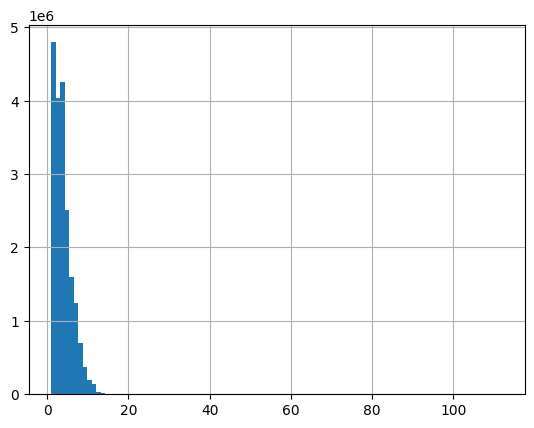

In [5]:
lengths = [len(w) for s in clean_text_lower for w in s.split()]


print(pd.Series(lengths, name="word_len").describe().round(2))
pd.Series(lengths, name="word_len").hist(bins = 100)

### 1.2 Токенизация

In [ ]:
from transformers import AutoTokenizer
import numpy as np


tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True)        
tokenizer.add_special_tokens({"pad_token": "<PAD>"})     
EOS = tokenizer.eos_token_id

texts = clean_text_lower.astype(str).tolist()

enc = tokenizer(
    texts,
    add_special_tokens=False,
    padding=False,
    truncation=False          
)

sequences = []
for ids in enc["input_ids"]:
    if not ids:
        continue
    sequences.append(ids + [EOS])

lens = np.array([len(s) for s in sequences])
print(f"Количество твитов: {len(lens)}")
print(f"min/median/mean/max: {lens.min()} / {np.median(lens):.1f} / {lens.mean():.1f} / {lens.max()}")
for q in [50, 75, 90, 95, 99]:
    print(f"p{q}: {int(np.percentile(lens, q))}")

[[707, 86, 11, 326, 338, 257, 275, 31647, 13, 345, 815, 64, 1392, 21970, 1097, 81, 286, 2368, 1110, 284, 466, 340, 13, 288, 50256], [271, 9247, 326, 339, 460, 470, 4296, 465, 23960, 416, 36634, 340, 13, 290, 1244, 3960, 355, 257, 1255, 1524, 1909, 635, 13, 33367, 50256], [72, 288, 1572, 867, 1661, 329, 262, 2613, 13, 5257, 284, 3613, 2026, 262, 1334, 467, 503, 286, 22303, 50256], [1820, 2187, 1767, 5300, 340, 29658, 290, 588, 663, 319, 2046, 50256], [3919, 11, 340, 338, 407, 37722, 379, 477, 13, 1312, 1101, 8805, 13, 1521, 716, 1312, 994, 780, 1312, 460, 470, 766, 345, 477, 625, 612, 13, 50256], [1662, 262, 2187, 5462, 50256], [31227, 257, 16225, 50256], [20342, 890, 640, 645, 766, 3763, 13, 29424, 257, 1643, 837, 8807, 257, 1643, 19462, 837, 1312, 1101, 3734, 5176, 837, 703, 338, 345, 50256], [77, 3008, 484, 1422, 470, 423, 340, 50256], [4188, 502, 38779, 8607, 50256], [16469, 2270, 287, 8631, 1748, 13, 340, 338, 6729, 278, 50256], [72, 655, 302, 41159, 616, 11368, 50256], [72, 3521, 

### 1.3 Разделение на трейн, валидацию и тест

In [10]:
import json
from sklearn.model_selection import train_test_split

train_seqs, temp = train_test_split(sequences, test_size=0.2, random_state=42, shuffle=True)
val_seqs,   test_seqs = train_test_split(temp, test_size=0.5, random_state=42, shuffle=True)


with open("data/train.json", "w", encoding="utf-8") as f:
    json.dump(train_seqs, f, ensure_ascii=False, separators=(",", ":"))
with open("data/val.json", "w", encoding="utf-8") as f:
    json.dump(val_seqs, f, ensure_ascii=False, separators=(",", ":"))
with open("data/test.json", "w", encoding="utf-8") as f:
    json.dump(test_seqs, f, ensure_ascii=False, separators=(",", ":"))

## 2 Обучение модели

In [ ]:
import pandas as pd
import ast
import os
from tqdm import tqdm
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoTokenizer

from src.dataset import NextTokenDataset
from src.model import RNNAutocompletion
import json



TRAIN_DATA_PATH = r"data\train.json"
VALID_DATA_PATH = r"data\val.json"
EXP_NAME = "exp1"
CHUNK_LEN = 32
STRIDE = CHUNK_LEN
EPOCHS = 100
BATCH_SIZE = 256
LR = 2e-3
DIM = 512
NUM_LAYERS = 2
DROPOUT = 0.3

with open(TRAIN_DATA_PATH, "r", encoding="utf-8") as f:
    train_sequences = json.load(f)  

with open(VALID_DATA_PATH, "r", encoding="utf-8") as f:
    valid_sequences = json.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True)
tokenizer.add_special_tokens({"pad_token": "<PAD>"})
pad_token_id = tokenizer.pad_token_id
eos_token_id = tokenizer.eos_token_id
vocab_size = len(tokenizer)

dataset_train = NextTokenDataset(train_sequences, chunk_length=CHUNK_LEN, stride=STRIDE, offset=0)
dataset_val = NextTokenDataset(valid_sequences, chunk_length=CHUNK_LEN, stride=STRIDE, offset=0)

dl_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
dl_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

model = RNNAutocompletion(
    vocab_size=vocab_size,
    pad_token_id=pad_token_id,
    eos_token_id=eos_token_id,
    dim=DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
    ).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=2,
    min_lr=1e-4,
)

save_path = os.path.join("exp", EXP_NAME)
os.makedirs(f"{save_path}/weights", exist_ok=True)
writer = SummaryWriter(log_dir=f"{save_path}/logs")

best_val_loss = float("inf")
train_step = 0

for epoch in range(EPOCHS):

    model.eval()
    val_losses = []
    val_correct = 0
    val_correct_top5 = 0
    val_total = 0

    with torch.no_grad(), torch.amp.autocast():
        for batch in tqdm(dl_val, desc=f"Epoch {epoch} valid", unit="batch"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            logits, _ = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
            val_losses.append(loss.item())

            preds = logits.argmax(dim=-1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.numel()

            _, top5 = logits.topk(5, dim=-1)
            val_correct_top5 += (top5 == labels.unsqueeze(-1)).any(dim=-1).sum().item()

    val_loss = np.mean(val_losses)
    val_ppl = np.exp(val_loss)
    val_acc = val_correct / val_total
    val_acc_top5 = val_correct_top5 / val_total

    print(f"epoch {epoch} valid loss: {val_loss:.4f} | ppl: {val_ppl:.2f} "f"| acc@1: {val_acc:.4f} | acc@5: {val_acc_top5:.4f}")
    writer.add_scalar("Loss/valid", val_loss, epoch)
    writer.add_scalar("Perplexity/valid", val_ppl, epoch)
    writer.add_scalar("Acc/valid",  val_acc,  epoch)
    writer.add_scalar("Acc/valid_top5", val_acc_top5, epoch)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"{save_path}/weights/best.pt")

    model.train()
    train_losses = []

    for batch in tqdm(dl_train, desc=f"Epoch {epoch} train", unit="batch"):
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits, _ = model(input_ids)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)                                
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
        scaler.step(optimizer)                                    
        scaler.update()

        train_losses.append(loss.item())
        writer.add_scalar("Loss/train_step", loss.item(), train_step)
        scheduler.step(val_loss)
        train_step += 1

    train_loss = np.mean(train_losses)
    print(f"epoch {epoch} train loss: {train_loss:.4f}")
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("LR", scheduler.get_last_lr()[0], train_step)


torch.save(model.state_dict(), f"{save_path}/weights/last.pt")
writer.close()

cuda


C:\Users\pasha\AppData\Local\Temp\ipykernel_16664\1477669984.py:62: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\pasha\AppData\Local\Temp\ipykernel_16664\1477669984.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
Epoch 0 valid: 100%|██████████| 323/323 [00:21<00:00, 15.08batch/s]


epoch 0 valid loss: 95.6863 | ppl: 359759550238347806462976876271250148687872.00 | acc@1: 0.0002 | acc@5: 0.0006


Epoch 0 train:   0%|          | 0/2576 [00:00<?, ?batch/s]C:\Users\pasha\AppData\Local\Temp\ipykernel_16664\1477669984.py:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 0 train:  34%|███▍      | 881/2576 [01:45<03:17,  8.58batch/s]

In [ ]:
from tqdm import tqdm
import pandas as pd
import ast
from transformers import AutoTokenizer
import torch
from torch.utils.data import DataLoader

from src.model import RNNAutocompletion
from src.dataset import NextTokenDataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

DIM = 512
NUM_LAYERS = 2
DROPOUT = 0.3
MODEL_PATH = r"exp\exp2\weights\best.pt"
TRAIN_MAX_LENGTH = 32
BATCH_SIZE = 1024
TEST_DATA_PATH = r"data\test.csv"

tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
pad_token_id = tokenizer.pad_token_id
vocab_size = tokenizer.vocab_size

data_test = pd.read_csv(TEST_DATA_PATH)
data_test["input_ids"] = data_test["input_ids"].apply(ast.literal_eval)

dataset_test = NextTokenDataset(data_test, pad_token=pad_token_id, max_length=TRAIN_MAX_LENGTH)
dl_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

model = RNNAutocompletion(
    vocab_size=vocab_size,
    pad_token_id=pad_token_id,
    dim=DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint)
model.eval()

test_correct = 0
test_correct_top5 = 0
test_total = 0

with torch.no_grad(), torch.amp.autocast():
    for batch in tqdm(dl_test, desc=f"Test", unit="batch"):
        input_ids = batch["input_ids"].to(device)
        lengths = batch["length"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, lengths)

        preds = logits.argmax(dim=-1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.numel()

        _, top5 = logits.topk(5, dim=-1)
        test_correct_top5 += (top5 == labels.unsqueeze(-1)).any(dim=-1).sum().item()

test_acc = test_correct / test_total
test_acc_top5 = test_correct_top5 / test_total

print(f"Test acc@1: {test_acc:.4f} | acc@5: {test_acc_top5:.4f}")

cuda


C:\Users\pasha\AppData\Local\Temp\ipykernel_19796\1981359067.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
Test: 100%|██████████| 2411/2411 [00:55<00:00, 43.11batch/s]

Test acc@1: 0.2533 | acc@5: 0.4754


## Генерация с помощью distilgpt2 на валидационном датасете

In [1]:
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import pandas as pd
import ast
import torch
from tqdm import tqdm
import evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# === Константы ===
VAL_DATA_PATH     = r"data\val.csv"
GPT_MODEL_NAME    = "distilgpt2"
BATCH_SIZE        = 1024
TRAIN_MAX_LENGTH  = 8    # сколько токенов берём в контекст
MAX_REF_TOKENS    = 32    # сколько токенов берём в референс (и генерим)

# === Данные ===
data_val = pd.read_csv(VAL_DATA_PATH)
data_val["input_ids"] = data_val["input_ids"].apply(ast.literal_eval)

# === Токенизатор/модель/пайплайн ===
tokenizer = AutoTokenizer.from_pretrained(GPT_MODEL_NAME, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

model = AutoModelForCausalLM.from_pretrained(GPT_MODEL_NAME).to(device)
if device.type == "cuda":
    model = model.half()

generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=0 if device.type == "cuda" else -1
)

rouge = evaluate.load("rouge")

def ids_to_text(ids):
    return tokenizer.decode(ids, skip_special_tokens=True)

# === Готовим пары (context_text, reference_text) прямо из input_ids ===
contexts, references = [], []
for ids in data_val["input_ids"]:
    n = len(ids)
    if n < 2:
        continue
    pivot = min(TRAIN_MAX_LENGTH, n-1)           # гарантируем, что GT не пустой
    ctx_ids = ids[:pivot]
    ref_ids = ids[pivot : min(n, pivot + MAX_REF_TOKENS)]

    contexts.append(ids_to_text(ctx_ids))
    references.append(ids_to_text(ref_ids))

contexts = contexts[:10000]
references = references[:10000]
# print(len(contexts), len(data_val["input_ids"]))


# === Генерация батчами (только продолжение, без контекста) ===
predictions = []
for i in tqdm(range(0, len(contexts), BATCH_SIZE), desc="Gen", unit="batch"):
    batch_ctx = contexts[i:i+BATCH_SIZE]
    outs = generator(
        batch_ctx,
        max_new_tokens=MAX_REF_TOKENS,
        do_sample=True,
        top_p=0.95,
        temperature=0.8,
        return_full_text=False,
        batch_size=BATCH_SIZE
    )
    preds_batch = [o[0]["generated_text"] for o in outs]
    predictions.extend(preds_batch)

# === ROUGE по “чистым” продолжениям
scores = rouge.compute(predictions=predictions, references=references)
print(scores)


Device: cuda


Device set to use cuda:0
Gen: 100%|██████████| 10/10 [00:31<00:00,  3.11s/batch]


{'rouge1': np.float64(0.04988322987829735), 'rouge2': np.float64(0.0035631112645058607), 'rougeL': np.float64(0.04448395690190314), 'rougeLsum': np.float64(0.0450269886274611)}


In [ ]:




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



rouge = evaluate.load("rouge")

batch_size = 16
context_lengths = [1, 3, 9]
max_gen_tokens = 32

for n in context_lengths:
    print(f"\n==== Context length: {n} ====")
    
    all_predictions = []
    all_references = []

    for i in range(0, len(data_test.input_ids), batch_size):
        batch_messages = data_test.input_ids[i : i + batch_size]

        contexts = [msg[:n] for msg in batch_messages]
        contexts = torch.nn.utils.rnn.pad_sequence(
            [torch.tensor(c, dtype=torch.long) for c in contexts],
            batch_first=True,
            padding_value=pad_token_id
        ).to(device)

        references = [msg[n:] for msg in batch_messages]

        with torch.no_grad():
            generated_batch = model.generate(start_tokens=contexts, max_tokens=max_gen_tokens)

        for gen_tokens, ref in zip(generated_batch, references):
            pred_text = tokenizer.decode(gen_tokens.tolist(), skip_special_tokens=True)
            ref_text = tokenizer.decode(ref, skip_special_tokens=True)

            all_predictions.append(pred_text)
            all_references.append(ref_text)

    results = rouge.compute(predictions=all_predictions, references=all_references)
    print(f"ROUGE scores for context={n}: {results}")